# Skiing
<div style="text-align: center;">
    <img src="Image/skiing.png">
</div>

**Table of contents**<a id='toc0_'></a>    
- [Directory and Structure](#toc1_)    
- [Introduction](#toc2_)    
- [Experiment Design](#toc3_)    
- [Development of methods](#toc4_)    
  - [Import all necessary library](#toc4_1_)    
  - [Implement Environment Wrapper](#toc4_2_)    
  - [Implement the Heuristic Agent](#toc4_3_)    
  - [Training](#toc4_4_)    
    - [Parameter Settings](#toc4_4_1_)    
    - [Trying the Heuristic Agent](#toc4_4_2_)    
    - [Create the Environment, Agent, Heuristic Agent, Replay Memory](#toc4_4_3_)    
    - [Load the previous trained model](#toc4_4_4_)    
  - [Evaluate the model (Latest checkpoint)](#toc4_5_)    
- [Analysis of results](#toc5_)    
- [Conclusion](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Directory and Structure](#toc0_)
```
|-- skiing.ipynb # This file

|-- agent.py     # Contain the Agent Class

|-- memory.py    # Contain ReplayMemory Class  

|-- model.py     # Contain the DQN to control the agent 

```

# <a id='toc2_'></a>[Introduction](#toc0_)
In this experiment, we delve into the application of RL to the challenging Gym Skiing Atari environment, seeking to formulate the RL problem and design experiments to gauge the learning capabilities of a Deep Q-Network (DQN) model with __imitation learning__ by using the episode generated by heuristic agent to train the DQN. 

The formulation of the RL problem involves defining the state space, action space, and reward structure to guide the learning process effectively. The state, action and reward of the Skiing Environment is as follows:
* The state at each step, $s_t$ is represented as a cropped gray scale image with shape = (130, 144). To let the DQN model have the previous state information, continuous 4 states with shape (4,130,144) is passed to the DQN model to obtain the action.

* The agent has 3 possible actions and it can perform 1 action at each step, $a_t$. Since the action is discrete, the selection for DNN will be DQN as only single forward pass is needed to obtain an action. The action value and its corresponding meaning is as follows:

| Value | Meaning |
|:-:|:-:|
| 0     | NOOP    |
| 1     | RIGHT   |
| 2     | LEFT    |

* The reward is always -1 if the agent does not reach the goal state, and ~ -450 penalty given at the end of the game if the agent does not pass a flag in the game. In the game, there is total of 20 pair of flags. For example, if the agent does not pass 10 pairs of flag in an episode, -4500 penalty will only be given at the end of the game

# <a id='toc3_'></a>[Experiment Design](#toc0_)

* First, the selection of the Deep Learning Model will be the Rainbow DQN and it is the same for the __Pong__ environment. The only difference is that in this case we are dealing with an image, so some convolutional layers are added in the beginning of neural network to extract the features from the images. The model architecture is shown below:

    <img src="Image/DQN_Skiing.png" width=600px>

* Secondly, to facilitate faster training speed of Rainbow DQN, a __Heuristic Agent__ that does not have the optimal action, but can pass all the flags in each games is built to guide the training of the Rainbow DQN. The pseudocode of sampling an episode for training is as follows, with 80% probability that the action is sampled by the heuristic agent, 10% probability for a random policy to facilitate exploration, and 10% based on the action of DQN to facilitate exploitation. The policy used to select actions from DQN is based on the softmax policy.
```
if rand_value < 0.8:   # Sample action from heuristic agent
    action = heuristic_agent.get_action(raw_obs)
elif rand_value < 0.9: # Sample action from DQN
    action          = dqn.act(state)[0] # Choose an action greedily (with noisy weights)         
else:                  # Sample action from random policy
    action = random.randint(0,2)
```
* At each 50000 steps of training, a checkpoint will be saved for further analysis. After sufficient training, 5 models with difference stages are chosen to investigate the effectiveness of the learning process. The key metrics considered for evaluation of effectiveness are the __average number of time steps taken to finish a game for n episodes__, and the __average accumulated rewards achieved for n episodes__. In our case, n is set to be 10.

# <a id='toc4_'></a>[Development of methods](#toc0_)

## <a id='toc4_1_'></a>[Import all necessary library](#toc0_)


In [1]:
# 2 additional library is require to running the skiing environment
# !pip install gym[atari]
# !pip install autorom[accept-rom-license]

In [2]:
from __future__ import division
from IPython import display
import os
import sys
from collections import deque

import random
import argparse
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import retro
import gym
import cv2
import torch
from torchsummary import summary

# Pre-defined library
from agent import Agent
from memory import ReplayMemory

sys.argv = ['']

In [3]:
gym.__version__ 

'0.21.0'

## <a id='toc4_2_'></a>[Implement Environment Wrapper](#toc0_)

In [4]:
class Env_Wrapper(gym.Wrapper):
    def __init__(self, env, args):
        super(Env_Wrapper, self).__init__(env)
        # Set up parameters 
        self.window       = args.history_length             # Number of frames to save in the history
        self.state_buffer =  deque([], maxlen=self.window)  # Buffer to store historical frames 
        self.device       = args.device                     # Running on either 'cpu' or 'cuda'
        self.env          = env                             # Refrence to the original environment 
        
    def _reset_buffer(self):
        # Reset the state buffer with zero tensors 
        for _ in range(self.window):
            self.state_buffer.append(torch.zeros(130, 144, device=self.device))
    
    def process_state(self, state):
        # Preprocess the state by converting to grayscale 
        gray = cv2.cvtColor(state[28:-52,8:152], cv2.COLOR_RGB2GRAY)
        return torch.tensor(gray, device = self.device)
        
    def reset(self):
        # Reset the state buffer and obtain the initial satet from the environment 
        self._reset_buffer()
        raw_state       = self.env.reset()  #
        processed_state = self.process_state(raw_state)
        
        # Update the state buffer with the processed state
        self.state_buffer.append(processed_state)
        
        # return the raw state and the stacked state buffer where each being normalize to [0,1]
        return raw_state, torch.stack(list(self.state_buffer) , 0) / 255
    
    def step(self, action):
        # Select an action in the environment and obtain the next state 
        next_state, reward, done, info = self.env.step(action)
        
        # preprocess the next state
        processed_state = self.process_state(next_state)
        
        # Update the state buffer with the preprocessed state
        self.state_buffer.append(processed_state)
        
        # Return (next state, normalized stacked state buffer, reward, end_status, info) 
        return next_state, torch.stack(list(self.state_buffer), 0) / 255, reward, done, info

## <a id='toc4_3_'></a>[Implement the Heuristic Agent](#toc0_)

* Reference: https://github.com/jaywalnut310/rl-atari-skiing/blob/master/heuristic_markovian_agent.ipynb

In [5]:
class Heuristic_Agent:
    # Objects can be distinquished by RGB codes.
    # Player: [214, 92, 92]
    # Flags (blue): [66, 72, 200]
    # Flags (red): [184, 50, 50]

    def __init__(self, env, observe):
        # Initialize the Heuristic Agent with the initial observation
        self.observe                       = observe
        self.observe_old                   = observe
        self.agent_x_old, self.agent_y_old = self.get_pos_player()
    
    def get_pos_player(self):
        # Find the position of the player in the observation
        ids = np.where(np.sum(self.observe == [214, 92, 92], -1) == 3)  # Find out the position of the player
        return ids[0].mean(), ids[1].mean()                        # Return the center of the player

    def get_pos_flags(self): 
        # Find the position of the flags in the observation                                   
        idx_red_flags  = np.sum(self.observe == [184, 50, 50], -1) == 3
        idx_blue_flags = np.sum(self.observe == [66, 72, 200], -1) == 3

        if np.any(idx_red_flags):   
            ids = np.where(idx_red_flags)
        elif np.any(idx_blue_flags):
            ids = np.where(idx_blue_flags)
        else:
            raise("Error in locating the color of red flags and blue flags")

        return ids[0].mean(), ids[1].mean()                        # Return the center of the flags

    def get_speed(self):
        # As the vertical location of the player is not changed, 
        # I estimate the vertical speed by measuring how much frames are shifted up.
        min_val = np.inf
        min_idx = 0
        for k in range(0, 7):
            val = np.sum(np.abs(self.observe[54:-52,8:152] - self.observe_old[54+k:-52+k,8:152]))
            if min_val > val:
                min_idx = k
                min_val = val
        return min_idx
    
    def get_action(self, observe):
        self.observe     = observe

        self.agent_x, self.agent_y             = self.get_pos_player() # Get the position of the agent
        self.flag_center_x, self.flag_center_y = self.get_pos_flags()  # Get the position of the flags
        self.speed                             = self.get_speed()      # Get the speed of the agent

        v_f = np.arctan2(self.flag_center_x - self.agent_x, self.flag_center_y - self.agent_y) # Direction from player to target
        v_a = np.arctan2(self.speed, self.agent_y - self.agent_y_old)                     # speed vector of the player


        if self.speed == 0 and (self.agent_y - self.agent_y_old) == 0:   # If the agent stop moving
            action = np.random.choice(3, 1)[0]
        else:
            if v_f - v_a < -0.1:   # Move Right
                action = 1  
            elif v_f - v_a > 0.1:  # Move Left
                action = 2
            else:
                action = 0         # Noop
        
        # Update the old observation
        self.agent_y_old = self.agent_y
        self.observe_old = observe
    
        return action

In [6]:
def render(x, step, reward):
    display.clear_output(wait=True)

    plt.figure(figsize=(6, 6))
    plt.clf()
    plt.axis("off")

    plt.title(f"step: {step}, r={reward}")
    plt.imshow(x, cmap=plt.cm.gray)
    plt.pause(0.0001)   # pause for plots to update

## <a id='toc4_4_'></a>[Training](#toc0_)

### <a id='toc4_4_1_'></a>[Parameter Settings](#toc0_)
* Note that hyperparameters may originally be reported in ATARI game frames instead of agent steps

In [7]:
parser = argparse.ArgumentParser(description='Rainbow')
parser.add_argument('--num-action', type=int, default=3, help='Experiment ID')
parser.add_argument('--id', type=str, default='default', help='Experiment ID')
parser.add_argument('--seed', type=int, default=123, help='Random seed')
parser.add_argument('--disable-cuda', action='store_true', help='Disable CUDA')
# parser.add_argument('--game', type=str, default='pong', choices=atari_py.list_games(), help='ATARI game')
parser.add_argument('--T-max', type=int, default=int(50e6), metavar='STEPS', help='Number of training steps (4x number of frames)')
parser.add_argument('--max-episode-length', type=int, default=int(108e3), metavar='LENGTH', help='Max episode length in game frames (0 to disable)')
parser.add_argument('--history-length', type=int, default=4, metavar='T', help='Number of consecutive states processed')
parser.add_argument('--architecture', type=str, default='canonical', choices=['canonical', 'data-efficient'], metavar='ARCH', help='Network architecture')
parser.add_argument('--hidden-size', type=int, default=512, metavar='SIZE', help='Network hidden size')
parser.add_argument('--noisy-std', type=float, default=0.1, metavar='σ', help='Initial standard deviation of noisy linear layers')
parser.add_argument('--atoms', type=int, default=51, metavar='C', help='Discretised size of value distribution')
parser.add_argument('--V-min', type=float, default=-10, metavar='V', help='Minimum of value distribution support')
parser.add_argument('--V-max', type=float, default=10, metavar='V', help='Maximum of value distribution support')
# parser.add_argument('--model', type=str, metavar='PARAMS', help='Pretrained model (state dict)')
parser.add_argument('--model', type=str, metavar='PARAMS', help='Pretrained model 1 (state dict)')
parser.add_argument('--model2', type=str, metavar='PARAMS', help='Pretrained model 2 (state dict)')
parser.add_argument('--memory-capacity', type=int, default=int(1e5), metavar='CAPACITY', help='Experience replay memory capacity')
parser.add_argument('--replay-frequency', type=int, default=32, metavar='k', help='Frequency of sampling from memory')
parser.add_argument('--priority-exponent', type=float, default=0.5, metavar='ω', help='Prioritised experience replay exponent (originally denoted α)')
parser.add_argument('--priority-weight', type=float, default=0.4, metavar='β', help='Initial prioritised experience replay importance sampling weight')
parser.add_argument('--multi-step', type=int, default=3, metavar='n', help='Number of steps for multi-step return')
parser.add_argument('--discount', type=float, default=0.99, metavar='γ', help='Discount factor')
parser.add_argument('--target-update', type=int, default=int(8e3), metavar='τ', help='Number of steps after which to update target network')
parser.add_argument('--reward-clip', type=int, default=1, metavar='VALUE', help='Reward clipping (0 to disable)')
parser.add_argument('--learning-rate', type=float, default=0.0000625, metavar='η', help='Learning rate')
parser.add_argument('--adam-eps', type=float, default=1.5e-4, metavar='ε', help='Adam epsilon')
parser.add_argument('--batch-size', type=int, default=256, metavar='SIZE', help='Batch size')
parser.add_argument('--norm-clip', type=float, default=10, metavar='NORM', help='Max L2 norm for gradient clipping')
parser.add_argument('--learn-start', type=int, default=int(20e3), metavar='STEPS', help='Number of steps before starting training')
parser.add_argument('--evaluate', action='store_true', help='Evaluate only')
parser.add_argument('--evaluation-interval', type=int, default=50000, metavar='STEPS', help='Number of training steps between evaluations')
parser.add_argument('--evaluation-episodes', type=int, default=2, metavar='N', help='Number of evaluation episodes to average over')
### TODO: Note that DeepMind's evaluation method is running the latest agent for 500K frames ever every 1M steps
parser.add_argument('--evaluation-size', type=int, default=500, metavar='N', help='Number of transitions to use for validating Q')
parser.add_argument('--render', action='store_true', help='Display screen (testing only)')
parser.add_argument('--enable-cudnn', action='store_true', help='Enable cuDNN (faster but nondeterministic)')
parser.add_argument('--checkpoint-interval', default=50000, help='How often to checkpoint the model, defaults to 0 (never checkpoint)')
parser.add_argument('--memory', help='Path to save/load the memory from')
parser.add_argument('--disable-bzip-memory', action='store_true', help='Don\'t zip the memory file. Not recommended (zipping is a bit slower and much, much smaller)')

_StoreTrueAction(option_strings=['--disable-bzip-memory'], dest='disable_bzip_memory', nargs=0, const=True, default=False, type=None, choices=None, help="Don't zip the memory file. Not recommended (zipping is a bit slower and much, much smaller)", metavar=None)

In [8]:
# Get the arguments and create the directory if it not exist
args = parser.parse_args()  # Parse command line arguments
os.makedirs("Model", exist_ok=True) # Create a directory named "Model" if it doesn't exist

# Set random seed
np.random.seed(args.seed)  # Set seed for NumPy random functions
torch.manual_seed(np.random.randint(1, 10000)) # Set seed for PyTorch random functions

# Print out each settings in the arguments
print("Parameter Settings")
for k, v in vars(args).items():
  print( f'{k:<20} : {str(v)} ')  # Print each parameter along with its value

Parameter Settings
num_action           : 3 
id                   : default 
seed                 : 123 
disable_cuda         : False 
T_max                : 50000000 
max_episode_length   : 108000 
history_length       : 4 
architecture         : canonical 
hidden_size          : 512 
noisy_std            : 0.1 
atoms                : 51 
V_min                : -10 
V_max                : 10 
model                : None 
model2               : None 
memory_capacity      : 100000 
replay_frequency     : 32 
priority_exponent    : 0.5 
priority_weight      : 0.4 
multi_step           : 3 
discount             : 0.99 
target_update        : 8000 
reward_clip          : 1 
learning_rate        : 6.25e-05 
adam_eps             : 0.00015 
batch_size           : 256 
norm_clip            : 10 
learn_start          : 20000 
evaluate             : False 
evaluation_interval  : 50000 
evaluation_episodes  : 2 
evaluation_size      : 500 
render               : False 
enable_cudnn         : Fals

In [9]:
# Select the device used to train the neural network
if torch.cuda.is_available() and not args.disable_cuda:
  # If CUDA (GPU) is available and not explicitly disabled in arguments
  args.device = torch.device('cuda') # Set the device to CUDA
  torch.cuda.manual_seed(np.random.randint(1, 10000)) # Set CUDA random seed
  torch.backends.cudnn.enabled = args.enable_cudnn # Enable cuDNN if specified
else:
  # If CUDA is not available or explicitly disabled
  args.device = torch.device('cpu') # Set the device to CPU
  
print(f"Device used: {args.device}") # Print the selected device

Device used: cuda


### <a id='toc4_4_2_'></a>[Trying the Heuristic Agent](#toc0_)

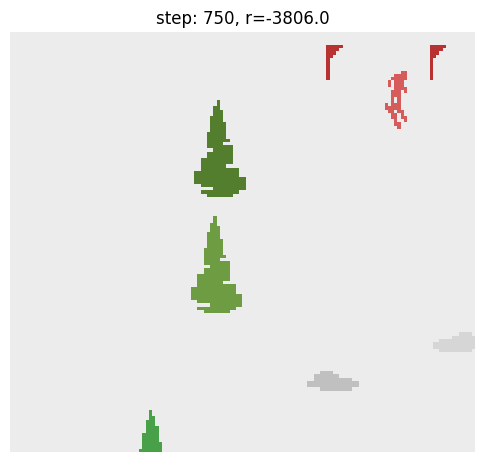

In [15]:
# Initial state
step             = 0
accu_reward      = 0                             # Accumulate Reward
env_name         = "Skiing-v4"
env              = Env_Wrapper(gym.make(env_name), args)
raw_obs, observe = env.reset()                # Initial observation
heuristic_agent  = Heuristic_Agent(env, raw_obs) # Initialize the heuristic agent  


while True:
    step += 1
    action = heuristic_agent.get_action(raw_obs)      # Get heuristic action
        
    raw_obs, observe, reward, done,  info = env.step(action) # Perform the action
    accu_reward                          += reward
    
    # Render the environment
    if step % 10 == 0 or done:
        render(raw_obs[28:-52,8:152], step, accu_reward) # Crop the image it only show the agent playing
#         render(raw_obs, step, accu_reward)
    
    if done: 
        break    

### <a id='toc4_4_3_'></a>[Create the Environment, Agent, Heuristic Agent, Replay Memory](#toc0_)

In [10]:
env_name         = "Skiing-v4"                           # Select Skiing version 4 as our environment
env              = Env_Wrapper(gym.make(env_name), args) # Create the environment
raw_obs, observe = env.reset()                           # Initial observation

dqn              = Agent(args, env)                        # Create Agent 
heuristic_agent  = Heuristic_Agent(env, raw_obs)           # Create Heuristic Agent Class
mem              = ReplayMemory(args, args.memory_capacity)# Create the memory buffer

priority_weight_increase = (1 - args.priority_weight) / (args.T_max - args.learn_start) # Priority Weight

In [11]:
summary(dqn.online_net, (4, 130, 144))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 8, 9]             --
|    └─Conv2d: 2-1                       [-1, 32, 130, 144]        6,304
|    └─ReLU: 2-2                         [-1, 32, 130, 144]        --
|    └─MaxPool2d: 2-3                    [-1, 32, 65, 72]          --
|    └─Conv2d: 2-4                       [-1, 64, 65, 72]          51,264
|    └─ReLU: 2-5                         [-1, 64, 65, 72]          --
|    └─MaxPool2d: 2-6                    [-1, 64, 32, 36]          --
|    └─Conv2d: 2-7                       [-1, 64, 32, 36]          102,464
|    └─ReLU: 2-8                         [-1, 64, 32, 36]          --
|    └─MaxPool2d: 2-9                    [-1, 64, 16, 18]          --
|    └─Conv2d: 2-10                      [-1, 32, 16, 18]          51,232
|    └─ReLU: 2-11                        [-1, 32, 16, 18]          --
|    └─MaxPool2d: 2-12                   [-1, 32, 8, 9]            --

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 8, 9]             --
|    └─Conv2d: 2-1                       [-1, 32, 130, 144]        6,304
|    └─ReLU: 2-2                         [-1, 32, 130, 144]        --
|    └─MaxPool2d: 2-3                    [-1, 32, 65, 72]          --
|    └─Conv2d: 2-4                       [-1, 64, 65, 72]          51,264
|    └─ReLU: 2-5                         [-1, 64, 65, 72]          --
|    └─MaxPool2d: 2-6                    [-1, 64, 32, 36]          --
|    └─Conv2d: 2-7                       [-1, 64, 32, 36]          102,464
|    └─ReLU: 2-8                         [-1, 64, 32, 36]          --
|    └─MaxPool2d: 2-9                    [-1, 64, 16, 18]          --
|    └─Conv2d: 2-10                      [-1, 32, 16, 18]          51,232
|    └─ReLU: 2-11                        [-1, 32, 16, 18]          --
|    └─MaxPool2d: 2-12                   [-1, 32, 8, 9]            --

### <a id='toc4_4_4_'></a>[Load the previous trained model](#toc0_)

In [12]:
# Find is there any model in the "/Model" directory
list_model  = os.listdir("Model")
if len(list_model) != 0:
  # Extract the epoch numbers from model filenames
  list_num = [int(mp[mp.index("_") + 1: mp.index(".")]) for mp in list_model]
  epoch_start  = np.max(list_num) # Pick the checkpoint model with the largest epoch trained 
else:
  epoch_start = 1

# Load the model if it exists
MODEL_PATH  = f"Model/DQN_{epoch_start}.pth"
if os.path.exists(MODEL_PATH):
    print("Load the model from",MODEL_PATH)
    # Load the state dict of the neural network from the saved model file
    dqn.online_net.load_state_dict(torch.load(MODEL_PATH, map_location=args.device))
    dqn.update_target_net() # Update the target network with the loaded weights
else:
    print("No pre-trained model is loaded")

print(f"Start training at epoch {epoch_start}")

Load the model from Model/DQN_6600000.pth
Start training at epoch 6600000


In [ ]:
# 4. Train the Agent
dqn.train()       # Set the deep learning model as train() mode
done   = True
RENDER = False

for T in trange(epoch_start, args.T_max + 1):
    torch.cuda.empty_cache()
    if done:   # Reset the env if it is done
        start_T        = T
        raw_obs, state = env.reset()
        accu_reward    =  0

    if T % args.replay_frequency == 0:  
        dqn.reset_noise()              # Draw a new set of noisy weights
    
    # Sample action from heuristic agent OR DQN OR random policy
    rand_value = random.random()
    if rand_value < 0.8:   # Sample action from heuristic agent
        action = heuristic_agent.get_action(raw_obs)
    elif rand_value < 0.9: # Sample action from DQN
        action = dqn.act(state)[0] # Choose an action based on softmax     
    else:                  # Sample action from random policy
        action = random.randint(0,2)
    
    raw_obs, next_state, reward, done,  info = env.step(action) # Perform the action
    

    # reward = max(min(reward, args.reward_clip), -args.reward_clip) # Clip reward
    
    accu_reward += reward
    if RENDER:
        if T % 10 == 0:
            render(raw_obs, T-start_T, accu_reward)
        
    mem.append(state[-1], action, reward, done)  # Append transition to memory for left paddle view
 

    # Train and test after accumulate enough sample from the episode
    if T-epoch_start >= args.learn_start:
        mem.priority_weight = min(mem.priority_weight + priority_weight_increase, 1)  # Anneal importance sampling weight β to 1

        # Train the model with n-step distributional double-Q learning
        if T % args.replay_frequency == 0:
            dqn.learn(mem)  

        # Update target network (DONE)
        if T % args.target_update == 0: 
            dqn.update_target_net()

        # Checkpoint the network (DONE)
        if (args.checkpoint_interval != 0) and (T % args.checkpoint_interval == 0):
            torch.save(dqn.online_net.state_dict(), f'Model/DQN_{T}.pth')

    state = next_state

## <a id='toc4_5_'></a>[Evaluate the model (Latest checkpoint)](#toc0_)

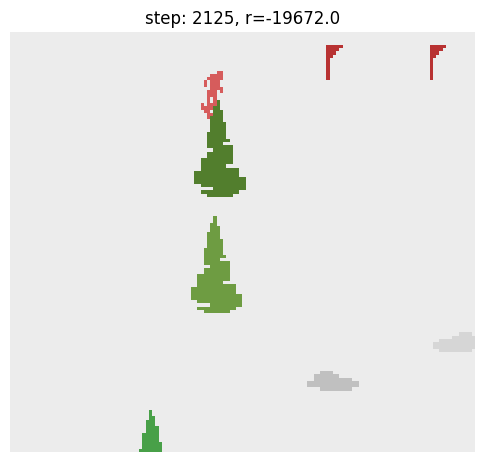

In [13]:
# Initial state
step             = 0
accu_reward      = 0                             # Accumulate Reward
env_name         = "Skiing-v4"
env              = Env_Wrapper(gym.make(env_name), args)
raw_obs, state   = env.reset()                # Initial observation
heuristic_agent  = Heuristic_Agent(env, raw_obs) # Initialize the heuristic agent  


while True:
    step += 1

    action = dqn.act(state)[0]      # Get action based on softmax
        
    raw_obs, state, reward, done,  info = env.step(action) # Perform the action
    accu_reward                          += reward
    
    # Render the environment
    if step % 10 == 0 or done:
        render(raw_obs[28:-52,8:152], step, accu_reward) # Crop the image it only show the agent playing
#         render(raw_obs, step, accu_reward)
    
    if done: 
        break    

# <a id='toc5_'></a>[Analysis of results](#toc0_)

In [119]:
pd.DataFrame(analysis)

,Model checkpoints,Num episodes,Average time step,Average rewards
0,Model/DQN_1400000.pth,10,1600,-15945.0
1,Model/DQN_2700000.pth,10,1671,-16898.0
2,Model/DQN_4000000.pth,10,1766,-17415.0
3,Model/DQN_5300000.pth,10,1595,-16418.0
4,Model/DQN_6600000.pth,10,1550,-15530.0


* The number of episodes used to generate episodes is consistent across different checkpoints, ensuring a fair comparison of the model's performance at each stage.

* The observed trend shows a gradual improvement in average rewards across training checkpoints.

# <a id='toc6_'></a>[Conclusion](#toc0_)
In conclusion, our analysis shows that the agent performance will gradually increase with the increasing training of the DQN. However, the __training__ is shown to be __very slow__ even though imitation learning (heuristic agent) is implemented to guide the agent while training.

To facilitate faster training speed, we can consider the following:
* Use __Policy Gradient based method__ like PPO. Since it directly optimizes the policy instead of optimizing the action value, Q, it always will have faster training speed than the Q-learning based method like Rainbow.
* __Tune the hyperparameters__ that influence exploration and exploitation
* __Implement some intermediate reward function__ to the agent when it passes the flags to teach the agent to pass the flag
* Since Heuristic Agent is implemented, there is a sufficient amount of good enough 'label' for training. Some __imitation learning loss like the cross entropy can be implemented__ to facilitate faster convergence in the training.